# Minst Clothing Classification using tensorflow
### Let's start by importing libararies required for this project

In [ ]:
import tensorflow as tf

# tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Herlper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Let's import Fashion MNIST dataset

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised= True, with_info= True)
train_ds, test_ds = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
class_names = metadata.features['label'].names
print('Class names: {}'.format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Let's get on with exploring the dataset by checking the number of images in training and test set.

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Number of images in train set: {}'.format(num_train_examples))
print('Number of images in test set: {}'.format(num_test_examples))

Number of images in train set: 60000
Number of images in test set: 10000


## Preprocessing dataset by normalizing the images in the range[0,1].

In [ ]:
# function for normalizing to make it easier for the optimization algorithm to find best weights during training.
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

In [ ]:
train_ds = train_ds.map(normalize)
test_ds = test_ds.map(normalize)

In [ ]:
# Caching will keep the dataset in memory, making training faster.
train_ds = train_ds.cache()
test_ds = test_ds.cache()

## Let's Explore the processed dataset

Let's visualize a Single Image __:__

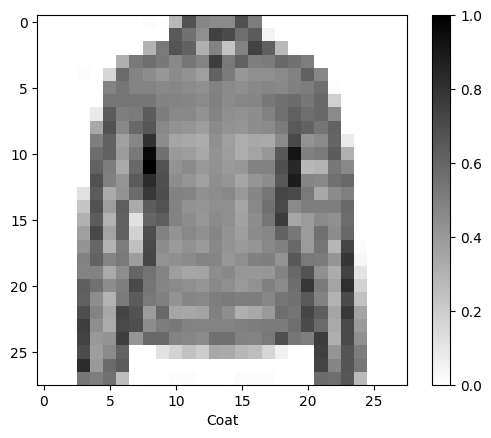

In [ ]:
for image, label in test_ds.take(1):
  break
image = image.numpy().reshape((28,28))
plt.figure()
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names[label])
plt.show()

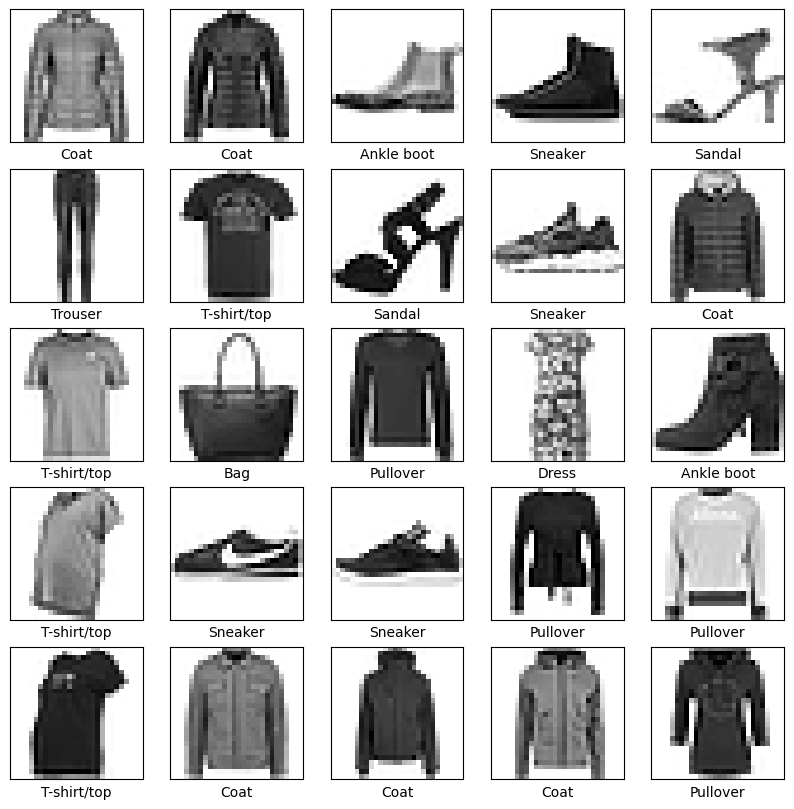

In [ ]:
plt.figure(figsize = (10,10))
for i, (image, label) in enumerate(test_ds.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap = plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show()

### Now let's build the model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
    tf.keras.layers.Dense(units = 128, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 10, activation = tf.nn.softmax)
])

### This network has three layers:
- **input**: `tf.keras.layers.Flatten` **--** This layer is used for input which transforms the 2d-array images of 28 X 28 pixels, to a 1d-array of 784 pixels (28*28).

- __hidden__: `tf.keras.layers.Dense` **—** It's a Dense layer of 128 neurons. Each neuron takes input from 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

- __output__: `tf.keras.layers.Dense` **—** THis is the output layer of 10-node _softmax_ layer. Where, each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in range [`0,1`], representing the probablity that the image belongs to that class. The sum of all 10 node values is 1.

## Compile the model

Before we train the model, we need to add a few more things which is done in the model's compile step:
- __Loss Function__ : An algorithm for measuring how far the model's outputs are from the desired output. The goal of this is measuring loss.

- __optimizer__ : An algorithm for adjusting the inner parameters of the model in order to minimize loss.

- __metrics__ : Used to monitor the training and testing steps. The following example uses _accuracy_, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer = 'adam',
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

## Train the model

First, we define the iteration behaviour for the train dataset:

1. Repeat forever by specifying `dataset.repeat()`.
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

In [ ]:
BATCH_SIZE = 32
train_ds = train_ds.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_ds = test_ds.cache().batch(BATCH_SIZE)

Training is performed using `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learn to associate images and labels.
3. The `epoch=5` parameter limits training to 5 full iterations of the training dataset, so a total of 60000*5 = 300000 examples.

In [ ]:
model.fit(train_ds, epochs = 5, steps_per_epoch= math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 12s 3ms/step - loss: 0.4932 - accuracy: 0.8272
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3751 - accuracy: 0.8639
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3337 - accuracy: 0.8792
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3123 - accuracy: 0.8848
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2949 - accuracy: 0.8913


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 89% on the training data.

# Evaluate accuracy

Let's see how our model performs on test data using all examples we have in test dataset.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds, steps = math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

Accuracy of test data is a little smaller than the accuracy on the training dataset. Which is completely normal, since our model was trained on `train_ds`. new images will have the lower accuracy.

# Make predictions and explore

As our model is trained let's use it to make predictions about some images.

In [ ]:
for test_images, test_labels in test_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 76ms/step


In [ ]:
predictions.shape

(32, 10)

In [ ]:
predictions[0]

array([2.4400457e-05, 9.0614520e-07, 6.3679689e-03, 9.7556544e-08,
       9.9218386e-01, 2.5620093e-08, 1.2780097e-03, 1.0035747e-08,
       1.4452070e-04, 2.9061965e-07], dtype=float32)

Above prediciton is an array of 10 numbers. These describe the "confidence" of the model that image corresponds to each of the 10 different articles of clothing. Here we can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

4

So the model is most confident that this image is coat, or `class_names[4]`. And we can check the test label to see this is correct:

In [ ]:
test_labels[0]

4

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap = plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label],
                                       100*np.max(predictions_array),
                                       class_names[true_label]),
                                        color = color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#777777')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

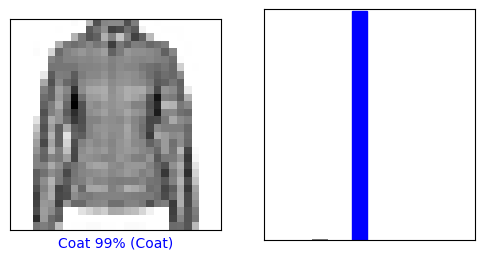

In [ ]:
i = 0
plt.figure(figsize = (6, 3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

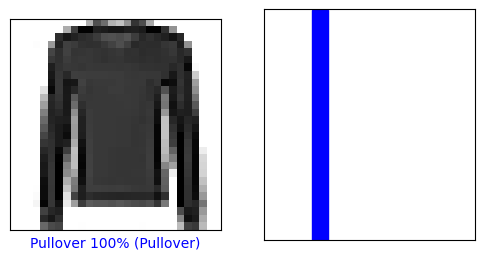

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i,predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. And, it can be wrong even when very confident.

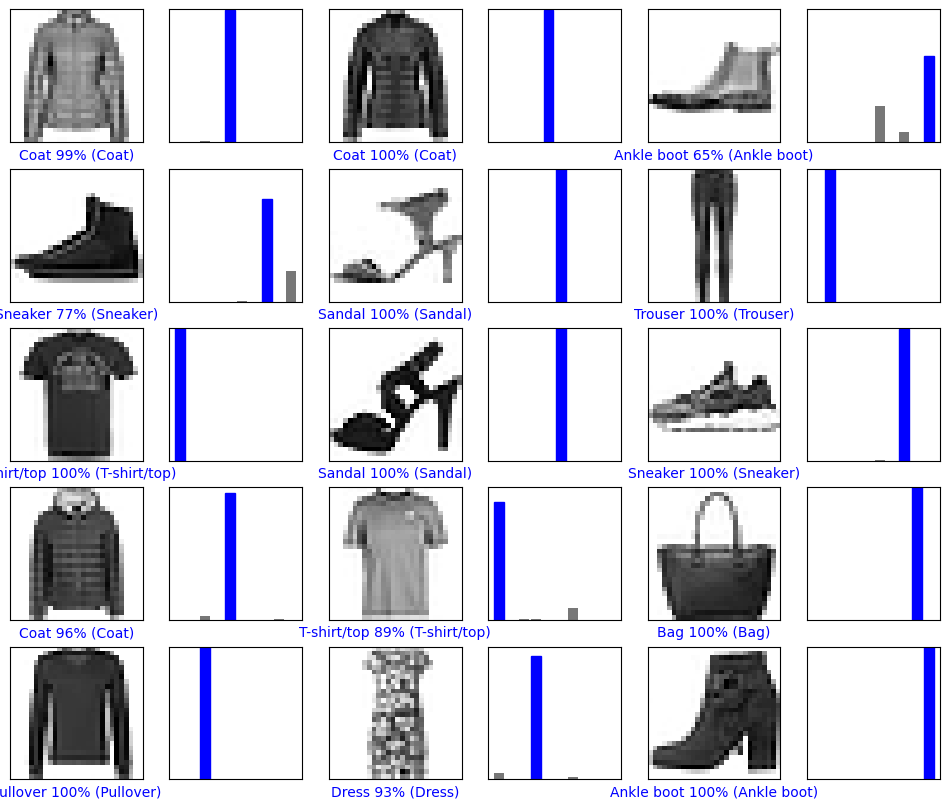

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize = (2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i,predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i,predictions, test_labels)

Lets predict a single image.

In [ ]:
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


Now predict the image

In [ ]:
predictions_single = model.predict(img)
print(predictions_single)

1/1 [==============================] - 0s 102ms/step
[[2.4400457e-05 9.0614520e-07 6.3679689e-03 9.7556544e-08 9.9218386e-01
  2.5620093e-08 1.2780097e-03 1.0035767e-08 1.4452085e-04 2.9061965e-07]]


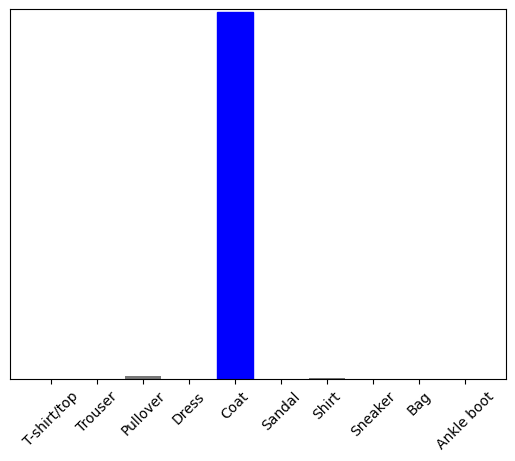

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation = 45)

`model.predict` returns a lists of lists, one for each image in the batch data. Grab the predictions for our (only) image in batch:

In [ ]:
np.argmax(predictions_single[0])

4

And as before, the model predicts a label of 4 (coat).